In [285]:
import numpy as np
import pandas as pd
import re
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from datetime import datetime

# Atención
Atención: Se va a utilizar el modelo viejo versión 2 ya que es el único que tiene una matriz de confusión lógica para rellenar los datos mientras que se intenta arreglar el modelo con 17 salidas

# Preparar los datos
Preparamos los datos previa separación. Codificamos numéricamente y eliminamos columnas que no vamos a utilizar

In [286]:
df = pd.read_csv('Datasets/Data_Combinada.csv', low_memory=False)

Eliminamos columnas que no utilizaremos, como las coordenadas, o columnas repetidas como distrito con código distrito y lesividad con código lesividad

In [287]:
df.drop(columns=['distrito', 'coordenada_y_utm', 'coordenada_x_utm', 'localizacion', 'numero', 'lesividad'],
        inplace=True)

In [288]:
df['sexo'].replace({'M': 0, 'H': 1}, inplace=True)

In [289]:
df['fugado'].replace({'No': 0, 'Si': 1}, inplace=True)

In [290]:
# El criterio según la fuente de datos es que si es None es nada, de todas formas si fue ingresado debería existir registro
# por lo que es muy raro el caso contrario
df['cod_lesividad'].fillna(0, inplace=True)

In [291]:
def marca_de_clase_rango_edad(edad: str) -> float:
    regex_format = r'\b\d+\b'
    numbers = re.findall(regex_format, edad)
    if len(numbers) >= 2:
        return (int(numbers[0]) + int(numbers[1])) / 2

    # if edad == 'Menor de 5 años':
    #     return 5
    # 
    # if edad == 'Más de 74 años':
    #     return 74
    else:
        return -1


df['rango_edad'] = df['rango_edad'].apply(marca_de_clase_rango_edad)
df.rename(columns={'rango_edad': 'marca_de_clase_edad'}, inplace=True)

In [292]:
print(sorted(df['marca_de_clase_edad'].unique()))

[-1.0, 7.5, 12.0, 16.0, 19.0, 22.5, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0]


In [293]:
def media_edad_pasajeros(list_age: tuple) -> float:
    age_sum = 0
    count = 0
    for age in list_age:
        if age != -1:
            age_sum = age_sum + age
            count = count + 1
    if count != 0:
        return age_sum / count
    return 0


df['media_edad_pasajeros'] = df.groupby('num_expediente')['marca_de_clase_edad'].transform(
    media_edad_pasajeros)
df['numero_pasajeros'] = df.groupby('num_expediente')['num_expediente'].transform('count')
df.head()

,num_expediente,fecha,hora,cod_distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,marca_de_clase_edad,sexo,cod_lesividad,positiva_alcohol,positiva_droga,numero_pasajeros,fugado,media_edad_pasajeros
0,2022S000001,01/01/2022,1:30:00,13.0,Alcance,Despejado,Turismo,Conductor,32.0,0,0.0,0.0,0.0,2,0,39.5
1,2022S000001,01/01/2022,1:30:00,13.0,Alcance,Despejado,Turismo,Conductor,47.0,1,0.0,0.0,0.0,2,0,39.5
2,2022S000002,01/01/2022,0:30:00,3.0,Colisión fronto-lateral,NaN,Motocicleta hasta 125cc,Conductor,32.0,1,0.0,1.0,0.0,3,0,37.0
3,2022S000002,01/01/2022,0:30:00,3.0,Colisión fronto-lateral,NaN,Motocicleta hasta 125cc,Pasajero,37.0,0,0.0,0.0,0.0,3,0,37.0
4,2022S000002,01/01/2022,0:30:00,3.0,Colisión fronto-lateral,NaN,Turismo,Conductor,42.0,1,0.0,0.0,0.0,3,0,37.0


In [294]:
# # TODO Pruebas eficiencia modelo IA Dropeamos todos los que no son conductores y dropeamos la columna luego ya que es redundante
df.drop(df[df['tipo_persona'] != 'Conductor'].index, inplace=True)
df.pop('tipo_persona')

0        Conductor
1        Conductor
2        Conductor
4        Conductor
5        Conductor
           ...    
74955    Conductor
74957    Conductor
74958    Conductor
74959    Conductor
74960    Conductor
Name: tipo_persona, Length: 60493, dtype: object

In [295]:
def minutes_from_midnight(hour_str: str) -> int:
    clock = hour_str.split(':')
    minutes = 0

    minutes = int(clock[0]) * 60
    minutes = minutes + int(clock[1])

    return minutes


df['minutes_from_midnight'] = df['hora'].apply(minutes_from_midnight)
df.pop('hora').head()

0    1:30:00
1    1:30:00
2    0:30:00
4    0:30:00
5    1:50:00
Name: hora, dtype: object

In [296]:
def extract_day(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[0])


def extract_month(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[1])


def extract_year(date_str: str) -> int:
    date_parts = date_str.split('/')
    if len(date_parts) >= 3:
        return int(date_parts[2])


df['day'] = df['fecha'].transform(extract_day)
df['month'] = df['fecha'].transform(extract_month)
df['year'] = df['fecha'].transform(extract_year)

In [297]:
def is_work_day(date_str: str) -> int:
    date_format = '%d/%m/%Y'  # Formato para 'dd-MM-yyyy'

    holidays_madrid = ['']  # todo
    try:
        date_obj = datetime.strptime(date_str, date_format)
        day_of_week_int = date_obj.weekday()
        if day_of_week_int == 5 or day_of_week_int == 6 or date_str in holidays_madrid:
            return 0
        return 1

    except ValueError:
        return -1


df['bool_laborable'] = df['fecha'].transform(is_work_day)
df.pop('fecha').head()

0    01/01/2022
1    01/01/2022
2    01/01/2022
4    01/01/2022
5    01/01/2022
Name: fecha, dtype: object

In [298]:
unique_values = df['tipo_accidente'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['tipo_accidente'] = df['tipo_accidente'].map(dictionary)

In [299]:
unique_values = df['tipo_vehiculo'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['tipo_vehiculo'] = df['tipo_vehiculo'].map(dictionary)

In [300]:
# TODO eliminar esto cuando se rellene con criterio
df['estado_meteorológico'].fillna('Desconocido', inplace=True)

unique_values = df['estado_meteorológico'].unique()
dictionary = {type_of: code for code, type_of in enumerate(unique_values)}
df['estado_meteorológico'] = df['estado_meteorológico'].map(dictionary)

In [301]:
df.isnull().any()

num_expediente           False
cod_distrito             False
tipo_accidente           False
estado_meteorológico     False
tipo_vehiculo            False
marca_de_clase_edad      False
sexo                     False
cod_lesividad            False
positiva_alcohol         False
positiva_droga           False
numero_pasajeros         False
fugado                   False
media_edad_pasajeros     False
minutes_from_midnight    False
day                      False
month                    False
year                     False
bool_laborable           False
dtype: bool

In [302]:
numero_implicados = df['num_expediente'].value_counts()
diccionario_expediente_implicados = numero_implicados.to_dict()
df['num_expediente'] = df['num_expediente'].map(diccionario_expediente_implicados)
df.rename(columns={'num_expediente': 'num_implicados'}, inplace=True)

df.head()

,num_implicados,cod_distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,marca_de_clase_edad,sexo,cod_lesividad,positiva_alcohol,positiva_droga,numero_pasajeros,fugado,media_edad_pasajeros,minutes_from_midnight,day,month,year,bool_laborable
0,2,13.0,0,0,0,32.0,0,0.0,0.0,0.0,2,0,39.5,90,1,1,2022,0
1,2,13.0,0,0,0,47.0,1,0.0,0.0,0.0,2,0,39.5,90,1,1,2022,0
2,2,3.0,1,1,1,32.0,1,0.0,1.0,0.0,3,0,37.0,30,1,1,2022,0
4,2,3.0,1,1,0,42.0,1,0.0,0.0,0.0,3,0,37.0,30,1,1,2022,0
5,1,1.0,2,0,2,-1.0,1,0.0,0.0,0.0,2,0,19.0,110,1,1,2022,0


In [303]:
df.pop('estado_meteorológico')
df.pop('fugado')
df.pop('year').head()

0    2022
1    2022
2    2022
4    2022
5    2022
Name: year, dtype: int64

In [304]:
correct_order = ['num_implicados', 'minutes_from_midnight', 'cod_distrito', 'tipo_accidente', 'tipo_vehiculo', 'sexo', 'positiva_alcohol', 'positiva_droga','bool_laborable', 'marca_de_clase_edad', 'day', 'month', 'media_edad_pasajeros', 'numero_pasajeros']
df = df[correct_order]
df.head()

,num_implicados,minutes_from_midnight,cod_distrito,tipo_accidente,tipo_vehiculo,sexo,positiva_alcohol,positiva_droga,bool_laborable,marca_de_clase_edad,day,month,media_edad_pasajeros,numero_pasajeros
0,2,90,13.0,0,0,0,0.0,0.0,0,32.0,1,1,39.5,2
1,2,90,13.0,0,0,1,0.0,0.0,0,47.0,1,1,39.5,2
2,2,30,3.0,1,1,1,1.0,0.0,0,32.0,1,1,37.0,3
4,2,30,3.0,1,0,1,0.0,0.0,0,42.0,1,1,37.0,3
5,1,110,1.0,2,2,1,0.0,0.0,0,-1.0,1,1,19.0,2


In [305]:
predict_df = df[df['marca_de_clase_edad'] == -1]
df_ex_predict = df.drop(predict_df.index)

In [306]:
print(sorted(df_ex_predict['marca_de_clase_edad'].unique()))

[7.5, 12.0, 16.0, 19.0, 22.5, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0]


In [307]:
# 'tipo_persona', 'sexo', 'positivo_alcohol', 'positivo_droga', 'fugado' no necesitan ser normalizadas
def custom_normalizer(__df: pd.DataFrame) -> None:
    cols_to_preserve = ['sexo', 'positiva_alcohol', 'positiva_droga', 'fugado', 'marca_de_clase_edad', 'bool_laborable']
    # Normalizar las demás columnas
    for col in __df.columns:
        if col not in cols_to_preserve:
            __df[col] = normalizer(df[col])

def normalizer(column: pd.Series) -> pd.Series:
    mean = column.mean()
    std = column.std() + 0.0000001  # evitamos dividir entre 0
    normalized_column = (column - mean) / std
    return normalized_column

In [308]:
custom_normalizer(df_ex_predict)
df_ex_predict = df_ex_predict[correct_order]
df_ex_predict.head()

,num_implicados,minutes_from_midnight,cod_distrito,tipo_accidente,tipo_vehiculo,sexo,positiva_alcohol,positiva_droga,bool_laborable,marca_de_clase_edad,day,month,media_edad_pasajeros,numero_pasajeros
0,-0.012232,-2.238222,0.552642,-1.078797,-0.458522,0,0.0,0.0,0,32.0,-1.675271,-1.446378,-0.016841,-0.407850
1,-0.012232,-2.238222,0.552642,-1.078797,-0.458522,1,0.0,0.0,0,47.0,-1.675271,-1.446378,-0.016841,-0.407850
2,-0.012232,-2.412535,-1.208375,-0.641271,-0.210317,1,1.0,0.0,0,32.0,-1.675271,-1.446378,-0.218953,0.493545
4,-0.012232,-2.412535,-1.208375,-0.641271,-0.458522,1,0.0,0.0,0,42.0,-1.675271,-1.446378,-0.218953,0.493545
7,-1.583257,-1.860543,1.785353,0.233782,-0.458522,1,0.0,0.0,0,52.0,-1.675271,-1.446378,1.195833,-0.407850


In [309]:
custom_normalizer(predict_df)
predict_df = predict_df[correct_order]
predict_df.head()

/tmp/ipykernel_19186/789485832.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  __df[col] = normalizer(df[col])


,num_implicados,minutes_from_midnight,cod_distrito,tipo_accidente,tipo_vehiculo,sexo,positiva_alcohol,positiva_droga,bool_laborable,marca_de_clase_edad,day,month,media_edad_pasajeros,numero_pasajeros
5,-1.583257,-2.180117,-1.560578,-0.203744,0.037887,1,0.0,0.0,0,-1.0,-1.675271,-1.446378,-1.674161,-0.407850
12,-0.012232,-1.584546,-0.503968,0.233782,-0.458522,1,0.0,0.0,0,-1.0,-1.675271,-1.446378,-1.027402,-0.407850
14,-1.583257,-1.570020,1.785353,0.233782,0.286092,1,0.0,0.0,0,-1.0,-1.675271,-1.446378,-1.916696,-0.407850
17,-0.012232,0.521740,0.024337,0.671308,-0.458522,1,0.0,0.0,0,-1.0,-1.675271,-1.446378,-0.218953,-0.407850
18,-1.583257,-1.584546,1.785353,0.233782,-0.458522,1,0.0,0.0,0,-1.0,-1.675271,-1.446378,-1.532683,0.493545


In [310]:
# TODO remove this when ready
df['marca_de_clase_edad'].count() - predict_df['marca_de_clase_edad'].count() - df_ex_predict[
    'marca_de_clase_edad'].count()

0

In [311]:
train_df, val_df = train_test_split(df_ex_predict, test_size=0.2, random_state=4321)

In [312]:
classes = [ 7.5, 12.0, 16.0, 19.0, 22.5, 27.0, 32.0, 37.0, 42.0, 47.0, 52.0, 57.0, 62.0, 67.0, 72.0]


def extract_labels(df, target_column, classes):
    labels = df[target_column].values

    one_hot_labels = []

    for label in labels:
        one_hot_vector = [1 if label == cls else 0 for cls in classes]
        one_hot_labels.append(one_hot_vector)

    return np.array(one_hot_labels)

In [313]:
train_labels = extract_labels(train_df, 'marca_de_clase_edad', classes)
val_labels = extract_labels(val_df, 'marca_de_clase_edad', classes)
train_data = train_df.drop('marca_de_clase_edad', axis=1).values
val_data = val_df.drop('marca_de_clase_edad', axis=1).values

In [314]:
model = load_model('bestmodelv2-0.31403.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [315]:
y_val_pred = model.predict(val_data)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(val_labels, axis=1)

print(classification_report(y_val_true, y_val_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.18      0.29        17
           2       0.67      0.28      0.39        36
           3       0.69      0.30      0.42       280
           4       0.64      0.32      0.42       743
           5       0.45      0.41      0.43      1255
           6       0.34      0.39      0.36      1276
           7       0.28      0.26      0.27      1204
           8       0.26      0.36      0.30      1322
           9       0.25      0.40      0.31      1315
          10       0.33      0.37      0.35      1184
          11       0.39      0.27      0.32       933
          12       0.50      0.21      0.29       598
          13       0.54      0.22      0.31       276
          14       0.70      0.18      0.28       175

    accuracy                           0.34     10616
   macro avg       0.45      0.28      0.32     10616
weighted avg       0.38   

/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/duo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


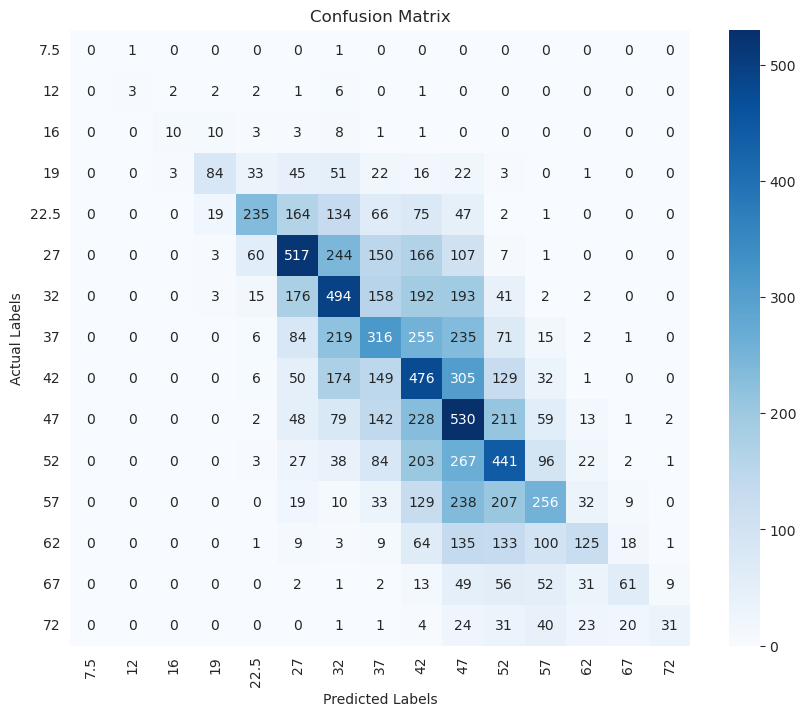

In [316]:
cm = confusion_matrix(y_val_true, y_val_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# Adding tick labels for better readability
classes = [7.5, 12, 16, 19, 22.5, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72] 
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=90)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)

plt.show()


Procedemos a reemplazar los datos

In [317]:
predict_df.pop('marca_de_clase_edad').head()

5    -1.0
12   -1.0
14   -1.0
17   -1.0
18   -1.0
Name: marca_de_clase_edad, dtype: float64

In [318]:
classes = [7.5, 12, 16, 19, 22.5, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72]
y_val_pred = model.predict(predict_df.values)
y_val_pred_indices = np.argmax(y_val_pred, axis=1)
y_val_pred_classes = [classes[index] for index in y_val_pred_indices]

predicted_classes_series = pd.Series(y_val_pred_classes, index=predict_df.index)

In [319]:
predicted_classes_series

5        19.0
12       27.0
14       19.0
17       37.0
18       22.5
         ... 
74881    52.0
74891    52.0
74894    32.0
74904    27.0
74955    47.0
Length: 7413, dtype: float64

In [322]:
df.loc[predicted_classes_series.index, 'marca_de_clase_edad'] = predicted_classes_series
df[df['marca_de_clase_edad'] == -1]

,num_implicados,minutes_from_midnight,cod_distrito,tipo_accidente,tipo_vehiculo,sexo,positiva_alcohol,positiva_droga,bool_laborable,marca_de_clase_edad,day,month,media_edad_pasajeros,numero_pasajeros


In [323]:
df.head()

,num_implicados,minutes_from_midnight,cod_distrito,tipo_accidente,tipo_vehiculo,sexo,positiva_alcohol,positiva_droga,bool_laborable,marca_de_clase_edad,day,month,media_edad_pasajeros,numero_pasajeros
0,2,90,13.0,0,0,0,0.0,0.0,0,32.0,1,1,39.5,2
1,2,90,13.0,0,0,1,0.0,0.0,0,47.0,1,1,39.5,2
2,2,30,3.0,1,1,1,1.0,0.0,0,32.0,1,1,37.0,3
4,2,30,3.0,1,0,1,0.0,0.0,0,42.0,1,1,37.0,3
5,1,110,1.0,2,2,1,0.0,0.0,0,19.0,1,1,19.0,2


In [324]:
df.to_csv('Datasets/Data_Combinada.v2')